In [184]:
import sys
sys.path.insert(0, "../")
from pathlib import Path
import joblib
import lightning as pl
import torch
from torchvision.io import read_image

import pandas as pd
import numpy as np
from tqdm import tqdm

from artstract_ml.dataset import load_perceptual_dataset, load_image_dataset
from artstract_ml.models.nn import VGG16ImageClassifier, ResNet50ImageClassifier, ViTImageClassifier

from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt

pl.seed_everything(42)


Global seed set to 42


42

## Interpret VGG16

In [185]:
finetuned_model = VGG16ImageClassifier.load_from_checkpoint("../output/vgg16_head/model.ckpt", num_classes=7, lr=0, only_head=False)

model = finetuned_model.model
model.classifier = model.classifier.append(finetuned_model.classifier)

train, valid, test = load_image_dataset(Path("../dataset/"), transform=finetuned_model.get_transforms())
labels = train.classes

transform = finetuned_model.get_transforms()

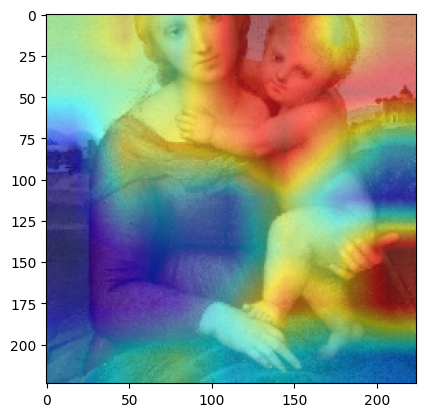

In [189]:
IMAGE_PATH = "../dataset/test/comfort/212.jpg"
LABEL = "danger"

img = read_image(IMAGE_PATH)
transformed_img = transform(img).unsqueeze(0)

with GradCAMPlusPlus(model=model, target_layers=[model.features[-1]], use_cuda=True) as explainer:
  targets = [ClassifierOutputTarget(labels.index(LABEL))]
  cam = explainer(input_tensor=transformed_img, targets=targets)[0, :]

  rgb_img = np.float32(transformed_img.squeeze(0).permute((1, 2, 0)))
  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

  cam_viz = show_cam_on_image(rgb_img, cam, use_rgb=True)

  plt.imshow(rgb_img)
  plt.imshow(cam_viz)

## Interpret ResNet

In [182]:
finetuned_model = ResNet50ImageClassifier.load_from_checkpoint("../output/resnet50_head/model.ckpt", num_classes=7, lr=0, only_head=False)

model = finetuned_model.model
model.add_module("classifier", finetuned_model.classifier)

train, valid, test = load_image_dataset(Path("../dataset/"), transform=finetuned_model.get_transforms())
labels = train.classes

transform = finetuned_model.get_transforms()

RuntimeError: Error(s) in loading state_dict for ResNet50ImageClassifier:
	size mismatch for classifier.weight: copying a param with shape torch.Size([8, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
	size mismatch for classifier.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([7]).

In [ ]:
IMAGE_PATH = "../dataset/test/comfort/212.jpg"
LABEL = "comfort"

img = read_image(IMAGE_PATH)
transformed_img = transform(img).unsqueeze(0)

with GradCAMPlusPlus(model=model, target_layers=[model.features[-1]], use_cuda=True) as explainer:
  targets = [ClassifierOutputTarget(labels.index(LABEL))]
  cam = explainer(input_tensor=transformed_img, targets=targets)[0, :]

  rgb_img = np.float32(transformed_img.squeeze(0).permute((1, 2, 0)))
  rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img))

  cam_viz = show_cam_on_image(rgb_img, cam, use_rgb=True)

  plt.imshow(rgb_img)
  plt.imshow(cam_viz)